In [2]:
import numpy as np 
import os
import cv2
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import os

NORMAL_VIDEO_DIR="/kaggle/input/shoplifting-dataset/Shoplifting dataset/Normal"
SHOPLIFTING_VIDEO_DIR="/kaggle/input/shoplifting-dataset/Shoplifting dataset/Shoplifting"

videoPath=[]
labels=[]

for dirname, _, filesname in os.walk(NORMAL_VIDEO_DIR):
    for filename in filesname:
        currVideoPath=os.path.join(NORMAL_VIDEO_DIR,filename)
        videoReader = cv2.VideoCapture(currVideoPath)
        count = int(videoReader.get(cv2.CAP_PROP_FRAME_COUNT))
        videoReader.release()
        if(count>=300):
            videoPath.append(currVideoPath)
            labels.append(0)
            
for dirname, _, filesname in os.walk(SHOPLIFTING_VIDEO_DIR):
    for filename in filesname:
        currVideoPath=os.path.join(SHOPLIFTING_VIDEO_DIR,filename)
        videoReader = cv2.VideoCapture(currVideoPath)
        count = int(videoReader.get(cv2.CAP_PROP_FRAME_COUNT))
        videoReader.release()
        if(count>=300):
            videoPath.append(currVideoPath)
            labels.append(1)

class VideoDataGenerator(Sequence):
    def __init__(self, video_paths, labels, batch_size,image_size, shuffle=True):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size=image_size
        self.shuffle = shuffle
        self.indices = np.arange(len(video_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.video_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = [self.load_video_n_resize_frames(self.video_paths[i]) for i in batch_indices]
        y_batch = [self.labels[i] for i in batch_indices]

        X_batch = np.array(X_batch)
        y_batch = np.array(y_batch)

        return X_batch, y_batch

    def load_video_n_resize_frames(self, video_path):
        video = []
        video_reader = cv2.VideoCapture(video_path)
        n = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
        start = (n - 300) // 2
        curr_count = 0
        flag = True

        while True:
            is_true, frame = video_reader.read()
            if len(video) >= 150:
                break
            if is_true:
                if curr_count >= start:
                    if flag==True:
                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        frame = cv2.resize(frame, image_size, interpolation=cv2.INTER_AREA)
                        video.append(np.array(frame))
                    flag=not flag
            else:
                break
            curr_count += 1

        video_reader.release()
        numpy_video = np.array(video)
        return numpy_video

batch_size = 2  # Adjust as needed
image_size=(224,224)
# image_size=(299,299)
trainVideoPath, testVideoPath, trainLabels, testLabels = train_test_split(videoPath,labels,test_size=0.25)
train_data_generator = VideoDataGenerator(trainVideoPath, trainLabels, batch_size,image_size)
val_data_generator = VideoDataGenerator(testVideoPath, testLabels, batch_size,image_size)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
noOfShopliftingTrain=0
noOfNormalTrain=0
noOfShopliftingVal=0
noOfNormalVal=0
for label in trainLabels:
    if label==0:
        noOfNormalTrain+=1
    else:
        noOfShopliftingTrain+=1
for label in testLabels:
    if label == 0:
        noOfNormalVal+=1
    else:
        noOfShopliftingVal+=1

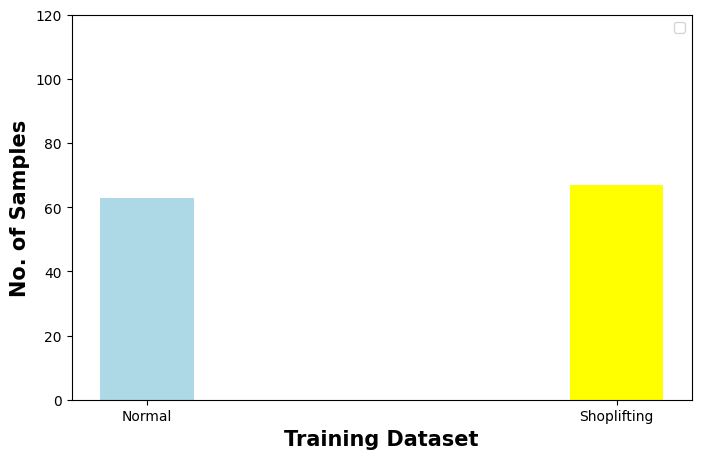

In [5]:
import matplotlib.pyplot as plt 
fig = plt.figure(figsize = (8, 5))
plt.bar("Normal",noOfNormalTrain, color ='lightblue', width = 0.2)
plt.bar("Shoplifting",noOfShopliftingTrain, color ='yellow', width = 0.2)
plt.xlabel('Training Dataset', fontweight ='bold', fontsize = 15) 
plt.ylabel('No. of Samples', fontweight ='bold', fontsize = 15) 
plt.ylim(0,120)
plt.legend()
plt.show() 

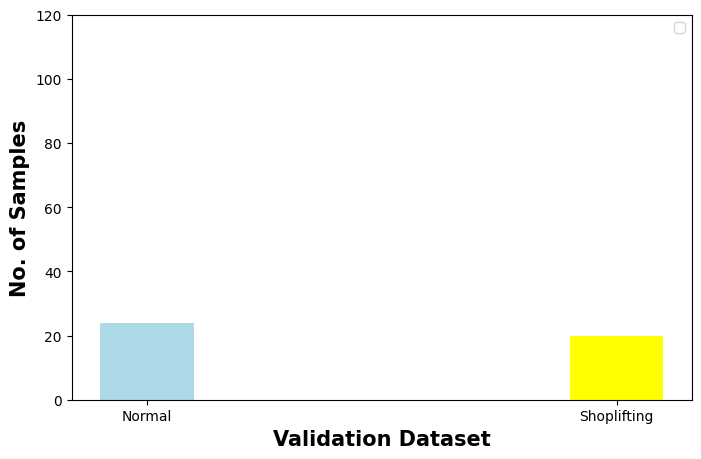

In [6]:
import matplotlib.pyplot as plt 
fig = plt.figure(figsize = (8, 5))
plt.bar("Normal",noOfNormalVal, color ='lightblue', width = 0.2)
plt.bar("Shoplifting",noOfShopliftingVal, color ='yellow', width = 0.2)
plt.xlabel('Validation Dataset', fontweight ='bold', fontsize = 15) 
plt.ylabel('No. of Samples', fontweight ='bold', fontsize = 15) 
plt.ylim(0,120)
plt.legend()
plt.show() 

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Dense

# Specify the input shape
input_shape = (150, 224, 224, 3)

# Create a Sequential model
model = Sequential()

# Define the Model Architecture.
model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                     recurrent_dropout=0.2, return_sequences=True, input_shape=input_shape))

model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                     recurrent_dropout=0.2, return_sequences=True))

model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                     recurrent_dropout=0.2, return_sequences=True))

model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                     recurrent_dropout=0.2, return_sequences=True))

model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model.add(Flatten())

model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model's summary.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 150, 222, 222, 4   1024      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 150, 111, 111, 4   0         
 D)                          )                                   
                                                                 
 time_distributed (TimeDist  (None, 150, 111, 111, 4   0         
 ributed)                    )                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 150, 109, 109, 8   3488      
                             )                                   
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 150, 55, 55, 8)    0

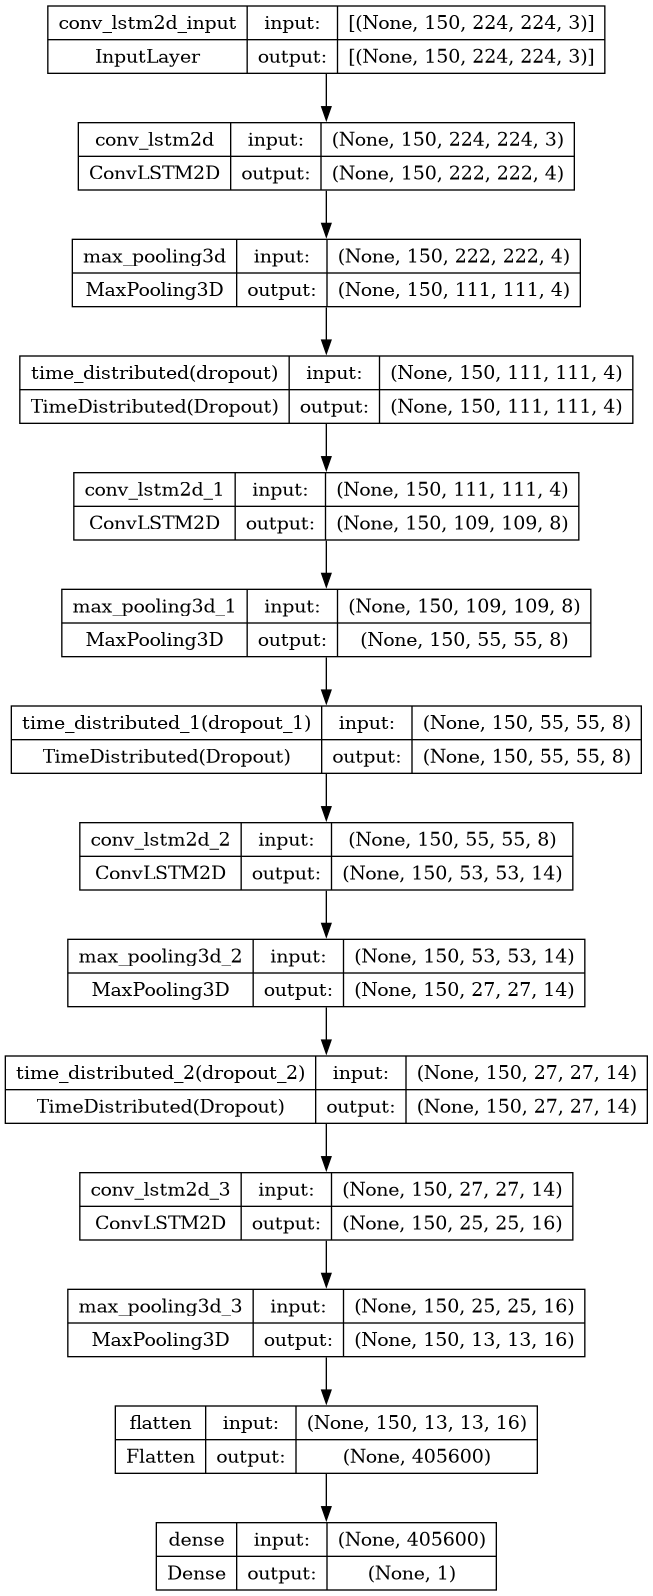

In [8]:
from keras.utils import plot_model

# Assuming you've already defined and compiled your model
# model = ...

# Specify the file name for saving the model's graph (optional)
plot_model(model, to_file='model_graph.png', show_shapes=True)

# If you don't want to save it as a file and only want to display it
# plot_model(model, show_shapes=True)


In [10]:
history = model.fit(train_data_generator , epochs=20, validation_data=val_data_generator)

Epoch 1/20
65/65 [==============================] - 284s 4s/step - loss: 0.7730 - accuracy: 0.5000 - val_loss: 0.5779 - val_accuracy: 0.7727
Epoch 2/20
65/65 [==============================] - 283s 4s/step - loss: 0.5541 - accuracy: 0.6923 - val_loss: 0.5993 - val_accuracy: 0.7955
Epoch 3/20
65/65 [==============================] - 288s 4s/step - loss: 0.4381 - accuracy: 0.8154 - val_loss: 0.6749 - val_accuracy: 0.7500
Epoch 4/20
65/65 [==============================] - 286s 4s/step - loss: 0.4125 - accuracy: 0.8462 - val_loss: 0.6776 - val_accuracy: 0.7045
Epoch 5/20
65/65 [==============================] - 287s 4s/step - loss: 0.3197 - accuracy: 0.8692 - val_loss: 0.5561 - val_accuracy: 0.7273
Epoch 6/20
65/65 [==============================] - 284s 4s/step - loss: 0.1783 - accuracy: 0.9538 - val_loss: 1.0855 - val_accuracy: 0.7045
Epoch 7/20
65/65 [==============================] - 283s 4s/step - loss: 0.2114 - accuracy: 0.9308 - val_loss: 0.9241 - val_accuracy: 0.7500
Epoch 8/20
65

In [11]:
import pandas as pd

Minimum Validation Loss: 0.5561


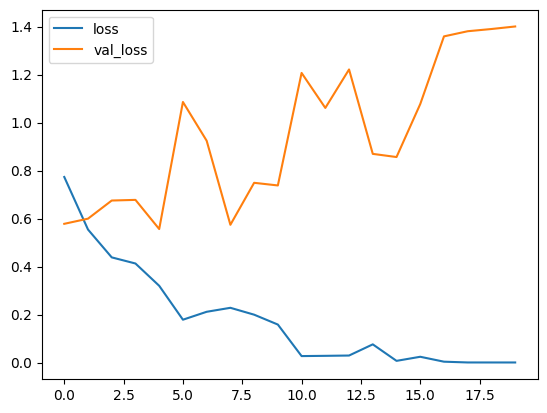

In [12]:
history_df = pd.DataFrame(history.history)
ax=history_df.loc[0:, ['loss', 'val_loss']].plot()
fig = ax.get_figure()
fig.savefig('loss_plot.png') 
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [13]:
history_df.to_csv('history_df.csv')

In [14]:
# from keras.models import Sequential
# from keras.layers import Dense
from keras.models import save_model

# # Create a simple model for demonstration
# model = Sequential()
# model.add(Dense(units=64, activation='relu', input_dim=100))
# model.add(Dense(units=10, activation='softmax'))

# # Compile the model (you should compile before training)
# model.compile(loss='categorical_crossentropy',
#               optimizer='sgd',
#               metrics=['accuracy'])

# Train the model (this is just for demonstration, actual training depends on your data)
# model.fit(x_train, y_train, epochs=5, batch_size=32)

# Save the model to a file
save_model(model, 'my_model.h5')


/tmp/ipykernel_42/706208647.py:19: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'my_model.h5')


In [15]:
from keras.models import load_model

# Load the saved model
loaded_model = load_model('/kaggle/working/my_model.h5')

# Now you can use loaded_model for predictions or further training
# For example:
# loaded_model.predict(new_data)


In [16]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 150, 222, 222, 4   1024      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 150, 111, 111, 4   0         
 D)                          )                                   
                                                                 
 time_distributed (TimeDist  (None, 150, 111, 111, 4   0         
 ributed)                    )                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 150, 109, 109, 8   3488      
                             )                                   
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 150, 55, 55, 8)    0

In [18]:
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.773043,0.500000,0.577877,0.772727
1,0.554056,0.692308,0.599340,0.795455
2,0.438056,0.815385,0.674902,0.750000
3,0.412526,0.846154,0.677614,0.704545
4,0.319691,0.869231,0.556141,0.727273


In [19]:
output=[]
predicted_output=[]
for i in range(len(val_data_generator)):
    predictions = model.predict(val_data_generator[i][0])
    for prediction in predictions:
        if prediction>=0.5:
            predicted_output.append(1)
        else:
            predicted_output.append(0)
    for trueOutput in val_data_generator[i][1]:
        output.append(trueOutput)

1/1 [==============================] - 1s 522ms/step


In [27]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [23]:
f1 = f1_score(output, predicted_output, average='weighted')

In [24]:
print("Classification Report:")
print(classification_report(output, predicted_output))

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.67      0.71        24
           1       0.65      0.75      0.70        20

    accuracy                           0.70        44
   macro avg       0.71      0.71      0.70        44
weighted avg       0.71      0.70      0.71        44



In [29]:
print("Weighted F1 Score:", f1)

Weighted F1 Score: 0.7050035236081748


In [31]:
print(conf_matrix)

[[16  8]
 [ 5 15]]


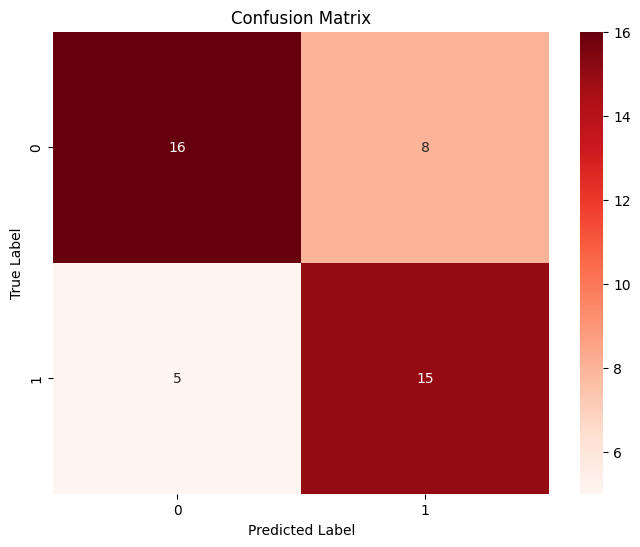

In [40]:
figure2=plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
fig3 = figure2.get_figure()
fig3.savefig('conf_matrix.png')
plt.show()